## AutoGluon model

In [1]:
import pandas as pd
import re
import datetime as dt
import numpy as np

import matplotlib.pyplot as plot

/Users/jenniferlittle/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### pull training data
- training will happen on data after release date (daily_gross)
- prior to release, covariate/indicators will be used to cluster similar films
    - wiki views

- predictions will require future data points:
    - locations, static metadata (genre, cluster, rating, date details(weekday, day_num))

In [1368]:
wiki_final_metrics_all = pd.read_csv('wiki_signals_mapped_2025-05-10.csv')

wiki_final_metrics_all['release_date'] = pd.to_datetime(wiki_final_metrics_all['release_date'])
wiki_final_metrics_all['wiki_date'] = pd.to_datetime(wiki_final_metrics_all['wiki_date'])

print(wiki_final_metrics_all.shape)
wiki_final_metrics_all.head(2)

(152861, 31)


,title,title_id,release_date,wiki_date,view_count,daily_page_count_views,tot_page_count_views,edits,abs_bytes_diff,rigor,...,views_prop_5d_ma,edits_5d_ma,rigor_5d_ma,view_count_cume_ma,view_count_cume,edits_cume,distributor,dist_category,covid,franchise
0,10 Cloverfield Lane,169,2016-03-11,2015-09-13,99.0,2.0,4.0,0.0,0.0,0.0,...,3.707506e-07,0.0,0.0,99.0,99.0,0.0,Paramount Pictures,major,pre_covid,0.0
1,10 Cloverfield Lane,169,2016-03-11,2015-09-14,100.0,3.0,4.0,0.0,0.0,0.0,...,3.689283e-07,0.0,0.0,149.0,199.0,0.0,Paramount Pictures,major,pre_covid,0.0


In [1369]:
## only need title id...
wiki_training = wiki_final_metrics_all[
    ['title','title_id','id','release_date','covid','franchise']].drop_duplicates()


print(wiki_training.title.nunique())
print(wiki_training.shape)
wiki_training.head(3)

868
(868, 6)


,title,title_id,id,release_date,covid,franchise
0,10 Cloverfield Lane,169,479cf33878,2016-03-11,pre_covid,0.0
180,102 Not Out,541,b94ccc0476,2018-05-04,pre_covid,0.0
360,12 Strong,468,290c047f57,2018-01-19,pre_covid,0.0


In [1370]:
wiki_training['title_id'] = wiki_training['title_id'].astype(str)

In [1371]:
wiki_training['release_date'].max()

Timestamp('2025-02-07 00:00:00')

### add genres

In [1372]:
imdb_meta = pd.read_csv('imdb_film_metadata_2025-05-10.csv')

imdb_meta['title_id'] = imdb_meta['title_id'].astype(str)

print(imdb_meta.shape)
imdb_meta.head(3)

(1321, 15)


,title,title_id,imdb_id,content_rating,release_date,Action_Adventure,Animation,Comedy,SciFi_Fantasy,Drama,Family,Mystery_Crime,Bio_History,Horror_Thriller,Romance
0,Weapons,1471,tt26581740,R,2025-08-08,0.0,0,0,0.0,0,0,1.0,0.0,1.0,0
1,How to Train Your Dragon,1469,tt26743210,PG,2025-06-13,1.0,0,1,0.0,0,0,0.0,0.0,0.0,0
2,Bring Her Back,1468,tt32246771,R,2025-05-30,0.0,0,0,0.0,0,0,1.0,0.0,1.0,0


In [1373]:
imdb_meta['content_rating'].value_counts()

content_rating
R            649
PG-13        411
PG           166
Not Rated     34
Unrated       13
TV-MA          5
G              2
Name: count, dtype: int64

In [1374]:
## dropout Not Rated, Unrated, and G
imdb_meta = imdb_meta[imdb_meta['content_rating'].isin(['R','PG-13','PG'])]

In [1375]:
## only need title id...
imdb_meta = imdb_meta[['title','title_id','content_rating','Action_Adventure',
                       'Animation', 'Comedy', 'SciFi_Fantasy', 'Drama', 'Family', 
                       'Mystery_Crime','Bio_History','Horror_Thriller', 'Romance',]].drop_duplicates()


print(imdb_meta.shape)

(1226, 13)


In [1376]:
### merge to wiki data
wiki_training = pd.merge(wiki_training, imdb_meta.drop(['title'], axis=1), on='title_id')

print(wiki_training.shape)
wiki_training.head(2)

(850, 17)


,title,title_id,id,release_date,covid,franchise,content_rating,Action_Adventure,Animation,Comedy,SciFi_Fantasy,Drama,Family,Mystery_Crime,Bio_History,Horror_Thriller,Romance
0,10 Cloverfield Lane,169,479cf33878,2016-03-11,pre_covid,0.0,PG-13,0.0,0,0,1.0,1,0,0.0,0.0,1.0,0
1,102 Not Out,541,b94ccc0476,2018-05-04,pre_covid,0.0,PG,0.0,0,1,0.0,1,0,0.0,0.0,0.0,0


In [1531]:
wiki_training['content_rating'].value_counts()

content_rating
R        433
PG-13    301
PG       116
Name: count, dtype: int64

### add clusters

In [1377]:
clusters_training = pd.read_csv('wiki_views_som_clusters_2025-05-10.csv')

## take cluster label, and also running sum of views and edits
## keep last row, which is total cume
clusters_training = clusters_training[['title_id','Cluster','view_count_cume','edits_cume']].drop_duplicates()
clusters_training = clusters_training.drop_duplicates('title_id', keep='last')

clusters_training['title_id'] = clusters_training['title_id'].astype(str)
clusters_training['Cluster'] = clusters_training['Cluster'].astype('category')

print(clusters_training.title_id.nunique())
print(clusters_training.shape)
clusters_training.head(3)

868
(868, 4)


,title_id,Cluster,view_count_cume,edits_cume
179,169,8,2737777.0,344.0
359,541,3,176268.0,49.0
539,468,2,1045640.0,96.0


In [1378]:
wiki_training = pd.merge(wiki_training, clusters_training, on='title_id')
print(wiki_training.shape)
wiki_training.head(2)

(850, 20)


,title,title_id,id,release_date,covid,franchise,content_rating,Action_Adventure,Animation,Comedy,SciFi_Fantasy,Drama,Family,Mystery_Crime,Bio_History,Horror_Thriller,Romance,Cluster,view_count_cume,edits_cume
0,10 Cloverfield Lane,169,479cf33878,2016-03-11,pre_covid,0.0,PG-13,0.0,0,0,1.0,1,0,0.0,0.0,1.0,0,8,2737777.0,344.0
1,102 Not Out,541,b94ccc0476,2018-05-04,pre_covid,0.0,PG,0.0,0,1,0.0,1,0,0.0,0.0,0.0,0,3,176268.0,49.0


In [1379]:
clusters_training.isna().sum()

title_id           0
Cluster            0
view_count_cume    0
edits_cume         0
dtype: int64

### pull theatrical grosses

In [1380]:
bom_cleaned = pd.read_csv('box_office_cleaned_2025-05-10.csv')

bom_cleaned['date'] = pd.to_datetime(bom_cleaned['date'])
bom_cleaned['release_date'] = pd.to_datetime(bom_cleaned['release_date'])


print(bom_cleaned.shape)
bom_cleaned.head()

(125097, 11)


,rank,film,theaters,psa,gross,cume,days_in_release,distributor,date,release_date,id
0,39,Only Yesterday2016 Re-release,1.0,6769.0,6769.0,6769.0,1,GKIDS,2016-01-01,2016-01-01,a8493c164e
1,41,Only Yesterday2016 Re-release,1.0,4418.0,4418.0,11187.0,2,GKIDS,2016-01-02,2016-01-01,a8493c164e
2,41,Only Yesterday2016 Re-release,1.0,3783.0,3783.0,14970.0,3,GKIDS,2016-01-03,2016-01-01,a8493c164e
3,37,Only Yesterday2016 Re-release,1.0,2173.0,2173.0,17143.0,4,GKIDS,2016-01-04,2016-01-01,a8493c164e
4,36,Only Yesterday2016 Re-release,1.0,2629.0,2629.0,19772.0,5,GKIDS,2016-01-05,2016-01-01,a8493c164e


In [1381]:
bom_cleaned.sort_values(['film','id','distributor','date'], inplace=True)

In [1382]:
bom_cleaned['week'] = pd.PeriodIndex(pd.to_datetime(bom_cleaned['date']), freq='W-THU').end_time.date
bom_cleaned['week_num'] = bom_cleaned.groupby(['id'])['week'].rank(method='dense').astype(int)

# bom_cleaned["weekday"] = pd.to_datetime(bom_cleaned["date"]).dt.weekday + 1 ### add 1 to weekday so there is no 0!!
bom_cleaned["weekday_name"] = pd.to_datetime(bom_cleaned["date"]).dt.day_name()

### merge wiki training data and box office

In [1383]:
bom_cleaned.head(3)

,rank,film,theaters,psa,gross,cume,days_in_release,distributor,date,release_date,id,week,week_num,weekday_name
2457,2,10 Cloverfield Lane,3391.0,2648.0,8981274.0,8981274.0,1,Paramount Pictures,2016-03-11,2016-03-11,479cf33878,2016-03-17,1,Friday
2458,2,10 Cloverfield Lane,3391.0,2855.0,9682560.0,18663834.0,2,Paramount Pictures,2016-03-12,2016-03-11,479cf33878,2016-03-17,1,Saturday
2459,2,10 Cloverfield Lane,3391.0,1788.0,6063603.0,24727437.0,3,Paramount Pictures,2016-03-13,2016-03-11,479cf33878,2016-03-17,1,Sunday


In [1384]:
wiki_training.head(3)

,title,title_id,id,release_date,covid,franchise,content_rating,Action_Adventure,Animation,Comedy,SciFi_Fantasy,Drama,Family,Mystery_Crime,Bio_History,Horror_Thriller,Romance,Cluster,view_count_cume,edits_cume
0,10 Cloverfield Lane,169,479cf33878,2016-03-11,pre_covid,0.0,PG-13,0.0,0,0,1.0,1,0,0.0,0.0,1.0,0,8,2737777.0,344.0
1,102 Not Out,541,b94ccc0476,2018-05-04,pre_covid,0.0,PG,0.0,0,1,0.0,1,0,0.0,0.0,0.0,0,3,176268.0,49.0
2,12 Strong,468,290c047f57,2018-01-19,pre_covid,0.0,R,1.0,0,0,0.0,1,0,0.0,1.0,0.0,0,2,1045640.0,96.0


In [1385]:
wiki_training2 = pd.merge(wiki_training, 
                          bom_cleaned[['id','theaters','gross','days_in_release',
                                      'date','week','week_num','weekday_name']], on=['id'])

print(wiki_training2.shape)
print(wiki_training2['title_id'].nunique())
wiki_training2.head(3)

(64086, 27)
850


,title,title_id,id,release_date,covid,franchise,content_rating,Action_Adventure,Animation,Comedy,...,Cluster,view_count_cume,edits_cume,theaters,gross,days_in_release,date,week,week_num,weekday_name
0,10 Cloverfield Lane,169,479cf33878,2016-03-11,pre_covid,0.0,PG-13,0.0,0,0,...,8,2737777.0,344.0,3391.0,8981274.0,1,2016-03-11,2016-03-17,1,Friday
1,10 Cloverfield Lane,169,479cf33878,2016-03-11,pre_covid,0.0,PG-13,0.0,0,0,...,8,2737777.0,344.0,3391.0,9682560.0,2,2016-03-12,2016-03-17,1,Saturday
2,10 Cloverfield Lane,169,479cf33878,2016-03-11,pre_covid,0.0,PG-13,0.0,0,0,...,8,2737777.0,344.0,3391.0,6063603.0,3,2016-03-13,2016-03-17,1,Sunday


In [1386]:
## label early release? non-standard release?
wiki_training2[(wiki_training2['days_in_release'] == 1) & 
               (wiki_training2['weekday_name'] != 'Friday')]

,title,title_id,id,release_date,covid,franchise,content_rating,Action_Adventure,Animation,Comedy,...,Cluster,view_count_cume,edits_cume,theaters,gross,days_in_release,date,week,week_num,weekday_name
252,1917,900,e2f546238e,2019-12-25,pre_covid,0.0,R,1.0,0,0,...,2,1376899.0,198.0,11.0,251262.0,1,2019-12-25,2019-12-26,1,Wednesday
359,20th Century Women,284,92c0aa2fa6,2016-12-28,pre_covid,0.0,R,0.0,0,1,...,3,161720.0,99.0,4.0,40296.0,1,2016-12-28,2016-12-29,1,Wednesday
718,A Journal for Jordan,1013,9324df5334,2021-12-25,covid,0.0,PG-13,0.0,0,0,...,3,292377.0,46.0,2500.0,1376032.0,1,2021-12-25,2021-12-30,1,Saturday
1973,Alita: Battle Angel,744,f9b8853c1a,2019-02-14,pre_covid,0.0,PG-13,1.0,0,0,...,1,2046309.0,318.0,3790.0,8716232.0,1,2019-02-14,2019-02-14,1,Thursday
2110,All The Money In The World,460,f498038544,2017-12-25,pre_covid,0.0,R,0.0,0,0,...,2,1121177.0,212.0,2074.0,2565393.0,1,2017-12-25,2017-12-28,1,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54944,Teenage Mutant Ninja Turtles: Mutant Mayhem,1180,49e55e92d7,2023-08-02,post_covid,1.0,PG,1.0,1,0,...,2,1178741.0,1324.0,3513.0,10202275.0,1,2023-08-02,2023-08-03,1,Wednesday
56462,The King's Man,1012,8f7950a254,2021-12-22,covid,0.0,R,1.0,0,0,...,2,1144646.0,68.0,3180.0,2275412.0,1,2021-12-22,2021-12-23,1,Wednesday
58372,Transformers: The Last Knight,349,81d263558a,2017-06-21,pre_covid,1.0,PG-13,1.0,0,0,...,5,3128169.0,1444.0,4069.0,15658535.0,1,2017-06-21,2017-06-22,1,Wednesday
60077,Vice,708,37b46c4707,2018-12-25,pre_covid,0.0,R,0.0,0,1,...,2,1163871.0,197.0,2378.0,4784212.0,1,2018-12-25,2018-12-27,1,Tuesday


### box plot

In [1045]:
### average box officer per cluster

w1 = wiki_training2.groupby(['title_id','Cluster'], observed=True).agg(
    {'view_count_cume':'mean','edits_cume':'mean','gross':'sum','title':'nunique'})
w1.reset_index(inplace=True)
w1.groupby(['Cluster'], observed=True).agg({'title':'sum',
                                           'view_count_cume':'mean','edits_cume':'mean','gross':'mean'}).round()

,title,view_count_cume,edits_cume,gross
Cluster,,,,
1,32,2642974.0,390.0,142424136.0
2,125,912740.0,174.0,62086071.0
3,296,240659.0,58.0,14762214.0
4,14,4970646.0,722.0,377367146.0
5,64,1807012.0,307.0,140452840.0
6,218,570234.0,112.0,37339084.0
7,4,8600490.0,889.0,435490206.0
8,24,3402174.0,509.0,275739008.0
9,73,1342283.0,223.0,89068153.0


/Users/jenniferlittle/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


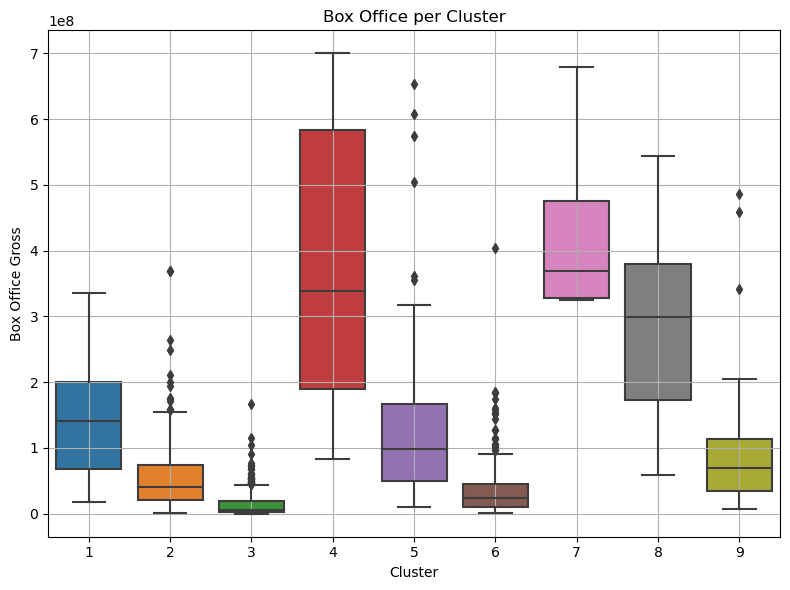

In [1207]:
plot.figure(figsize=(8, 6))
sns.boxplot(x='Cluster', y='gross', data=w1)
plot.title('Box Office per Cluster')
plot.xlabel('Cluster')
plot.ylabel('Box Office Gross')
plot.grid(True)
plot.tight_layout()
plot.show()


/Users/jenniferlittle/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


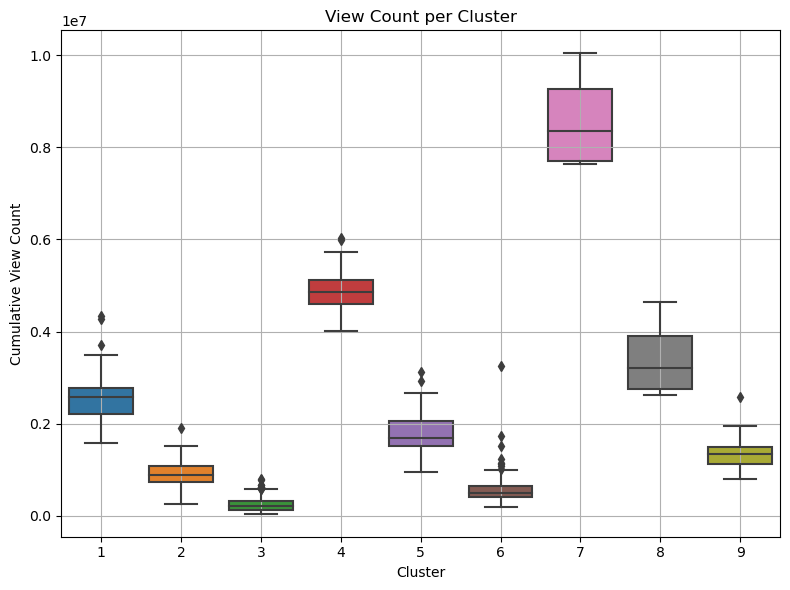

In [1211]:
plot.figure(figsize=(8,6))
sns.boxplot(x='Cluster', y='view_count_cume', data=w1)
plot.title('View Count per Cluster')
plot.xlabel('Cluster')
plot.ylabel('Cumulative View Count')
plot.grid(True)
plot.tight_layout()
plot.show()


### prepare train dataset

In [1046]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [1387]:
print(wiki_training2.shape)
print(wiki_training2.title_id.nunique())
wiki_training2.head(2)

(64086, 27)
850


,title,title_id,id,release_date,covid,franchise,content_rating,Action_Adventure,Animation,Comedy,...,Cluster,view_count_cume,edits_cume,theaters,gross,days_in_release,date,week,week_num,weekday_name
0,10 Cloverfield Lane,169,479cf33878,2016-03-11,pre_covid,0.0,PG-13,0.0,0,0,...,8,2737777.0,344.0,3391.0,8981274.0,1,2016-03-11,2016-03-17,1,Friday
1,10 Cloverfield Lane,169,479cf33878,2016-03-11,pre_covid,0.0,PG-13,0.0,0,0,...,8,2737777.0,344.0,3391.0,9682560.0,2,2016-03-12,2016-03-17,1,Saturday


In [1388]:
wiki_training2.rename(columns={'title_id':'item_id',
                               'gross':'daily_gross'}, inplace=True)

In [1389]:
wiki_training2.columns

Index(['title', 'item_id', 'id', 'release_date', 'covid', 'franchise',
       'content_rating', 'Action_Adventure', 'Animation', 'Comedy',
       'SciFi_Fantasy', 'Drama', 'Family', 'Mystery_Crime', 'Bio_History',
       'Horror_Thriller', 'Romance', 'Cluster', 'view_count_cume',
       'edits_cume', 'theaters', 'daily_gross', 'days_in_release', 'date',
       'week', 'week_num', 'weekday_name'],
      dtype='object')

In [1390]:
genre_cols = ['Action_Adventure', 'Animation', 'Comedy', 'SciFi_Fantasy', 'Drama',
              'Family', 'Mystery_Crime', 'Bio_History', 'Horror_Thriller','Romance']

In [36]:
# # Convert categorical features to strings
# categorical_cols = ['Cluster', 'season', 'rating', 'covid', 'early_release']
# for col in categorical_cols:
#     train_test_df[col] = train_test_df[col].astype('str')

In [1391]:
tdf = wiki_training2[['date','days_in_release','weekday_name', 
                      #'early_release',
                      'franchise', 
                     'content_rating',
                     'daily_gross','theaters','item_id','Cluster',
                     'view_count_cume', 'edits_cume','covid'] + genre_cols
                    ].copy()

tdf['date'] = pd.to_datetime(tdf['date'])

print(tdf.shape)
print(tdf.item_id.nunique())
tdf.head()

(64086, 22)
850


,date,days_in_release,weekday_name,franchise,content_rating,daily_gross,theaters,item_id,Cluster,view_count_cume,...,Action_Adventure,Animation,Comedy,SciFi_Fantasy,Drama,Family,Mystery_Crime,Bio_History,Horror_Thriller,Romance
0,2016-03-11,1,Friday,0.0,PG-13,8981274.0,3391.0,169,8,2737777.0,...,0.0,0,0,1.0,1,0,0.0,0.0,1.0,0
1,2016-03-12,2,Saturday,0.0,PG-13,9682560.0,3391.0,169,8,2737777.0,...,0.0,0,0,1.0,1,0,0.0,0.0,1.0,0
2,2016-03-13,3,Sunday,0.0,PG-13,6063603.0,3391.0,169,8,2737777.0,...,0.0,0,0,1.0,1,0,0.0,0.0,1.0,0
3,2016-03-14,4,Monday,0.0,PG-13,2087765.0,3391.0,169,8,2737777.0,...,0.0,0,0,1.0,1,0,0.0,0.0,1.0,0
4,2016-03-15,5,Tuesday,0.0,PG-13,2567729.0,3391.0,169,8,2737777.0,...,0.0,0,0,1.0,1,0,0.0,0.0,1.0,0


### reindex to make sure all consecutive daily grosses are present

In [1392]:
tdf_date_range = tdf.groupby(['item_id']).agg({'date':['min', 'max']})
tdf_date_range.columns = ['_'.join(c) for c in tdf_date_range.columns]

tdf_date_range.reset_index(inplace=True)

tdf_date_range['date_range'] = tdf_date_range.apply(lambda x: pd.date_range(
    x['date_min'], x['date_max']).tolist(), axis=1)

tdf_date_range.head()

,item_id,date_min,date_max,date_range
0,1001,2021-11-26,2022-04-07,"[2021-11-26 00:00:00, 2021-11-27 00:00:00, 202..."
1,1005,2021-12-10,2022-01-23,"[2021-12-10 00:00:00, 2021-12-11 00:00:00, 202..."
2,1006,2021-12-10,2022-04-07,"[2021-12-10 00:00:00, 2021-12-11 00:00:00, 202..."
3,1009,2021-12-17,2022-03-31,"[2021-12-17 00:00:00, 2021-12-18 00:00:00, 202..."
4,1010,2021-12-22,2022-05-05,"[2021-12-22 00:00:00, 2021-12-23 00:00:00, 202..."


In [1393]:
## explode out date range, so all dates are accounted for within range
tdf_date_range = tdf_date_range.groupby(['item_id'])['date_range'].sum().explode().to_frame()
tdf_date_range.reset_index(inplace=True)
tdf_date_range.columns = ['item_id','date']

tdf_date_range.head(3)

,item_id,date
0,1001,2021-11-26
1,1001,2021-11-27
2,1001,2021-11-28


In [1394]:
## merge full dates back to wiki data so missing dates are present
tdf = pd.merge(tdf, tdf_date_range, how='outer')
tdf.sort_values(['item_id', 'date'], inplace=True)

tdf['days_in_release'] = tdf.groupby(['item_id'])['date'].cumcount()+1
tdf.fillna({'daily_gross':0}, inplace=True)

tdf.head(2)

,date,days_in_release,weekday_name,franchise,content_rating,daily_gross,theaters,item_id,Cluster,view_count_cume,...,Action_Adventure,Animation,Comedy,SciFi_Fantasy,Drama,Family,Mystery_Crime,Bio_History,Horror_Thriller,Romance
45497,2021-11-26,1,Friday,0.0,R,141595.0,4.0,1001,6,913340.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
45511,2021-11-27,2,Saturday,0.0,R,104764.0,4.0,1001,6,913340.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [1395]:
## ignore more than 28 days...4 weeks of training data --> for 2-4 weeks of predictions
tdf = tdf[tdf['days_in_release'] <= 28]

In [1396]:
## ignore if missing data...

gaps = tdf[tdf['daily_gross'] == 0 ]['item_id'].unique().tolist()
print(len(gaps))
tdf = tdf[~tdf['item_id'].isin(gaps)]
print(tdf.item_id.nunique())
print(tdf.shape)

18
832
(23103, 22)


In [1397]:
## remove zeros...
# tdf = tdf[tdf['daily_gross'] != 0]

## ignore if any zeros reported daily gross...
tdf = tdf[~tdf.item_id.isin(tdf[tdf['daily_gross']== 0]['item_id'])]
print(tdf.item_id.nunique())
print(tdf.shape)

832
(23103, 22)


In [1398]:
## remove if not enough observations...
tdf=pd.merge(tdf,tdf.groupby(['item_id'],as_index=False)[['days_in_release']].max(),
             on='item_id',suffixes=('','_max'))

In [1399]:
tdf['days_in_release_max'].value_counts()

days_in_release_max
28    22456
21      483
23       92
24       72
Name: count, dtype: int64

In [1400]:
## must have at least 21 days of data...ok to keep all
tdf = tdf[tdf['days_in_release_max'] >= 21].copy()
tdf.drop(['days_in_release_max'], axis=1, inplace=True)

In [1401]:
print(tdf.shape)
print(tdf.item_id.nunique())
tdf.head(2)

(23103, 22)
832


,date,days_in_release,weekday_name,franchise,content_rating,daily_gross,theaters,item_id,Cluster,view_count_cume,...,Action_Adventure,Animation,Comedy,SciFi_Fantasy,Drama,Family,Mystery_Crime,Bio_History,Horror_Thriller,Romance
0,2021-11-26,1,Friday,0.0,R,141595.0,4.0,1001,6,913340.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,2021-11-27,2,Saturday,0.0,R,104764.0,4.0,1001,6,913340.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


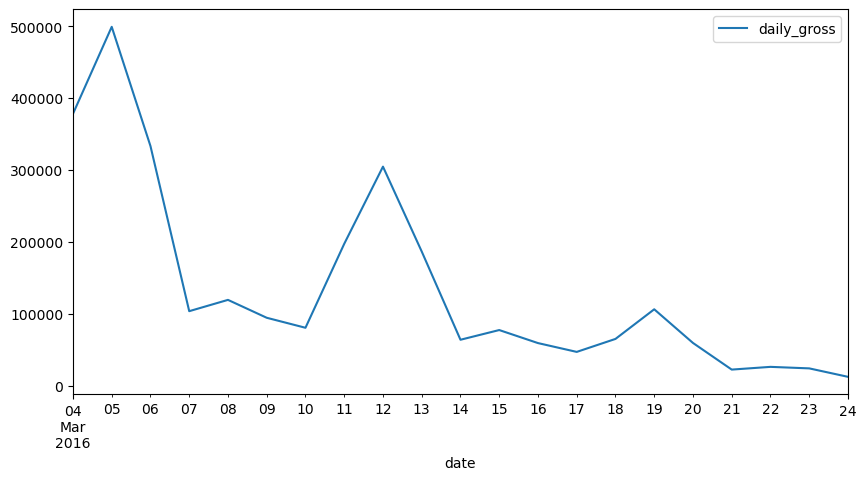

In [1402]:
## check data - 10 cloverfield lane
tdf[tdf['item_id'] == '164'].plot(x='date', y='daily_gross', figsize=(10, 5)); 

### holidays / seasons

add holiday features for training and test date range
focus on long weekends and christmas/new years
- christmas, new years, thanksgiving, memorial day, 4th of july, labor day

#### seasons
- Fall is the day after Labor Day weekend through the Thrusday before the first Friday in November.
- Summer is the first Friday in May through Labor Day weekend.
- Spring is the first Friday in March through the Thursday before the first Friday in May.
- Winter is the first day after New Year's week or weekend through the Thursday before the first Friday in March
- Holiday Season is the first week in November till the first Thursday before the first Friday in January, unless that Friday is New Years then it's the next Thursday.

In [1403]:
import holidays
import dateutil.easter

In [1532]:
def get_release_dates(df, date_col):
    
    release_dates = df[[date_col]].drop_duplicates()

    return release_dates
    

def get_week_ranges(release_dates, date_col):
    
    ### reindex week and weekend dates
    r1, r2 = release_dates[date_col].min(), release_dates[date_col].max()
    print(r1, r2)

    r_range = pd.date_range(r1, r2)
    r_range = pd.DataFrame(r_range, columns=['date'])
    
    return r1, r2, r_range


def get_first_fridays(r_range):
    
    first_friday = r_range[(r_range['day_name'] == 'Friday')].groupby([pd.Grouper(key='date', freq='MS')])[['date']].min()
    first_friday['first_friday'] = 1
    first_friday.reset_index(drop=True, inplace=True)
    
    return first_friday


def label_seasons(r_range):
        
    for yr in r_range['date'].dt.year.unique():
    #     print(yr)

        ## get min date for the year
        min_date = r_range.loc[(r_range['date'].dt.year == yr) & 
                               (r_range['season'].isna())]['date'].min()


        ## Winter
        tmp_date = r_range.loc[(r_range['date'].dt.year == yr) & 
                           (r_range['date'].dt.month == 1) & (r_range['first_friday'] == 1)]

        if not tmp_date.empty:

            if (~tmp_date['holiday'].isna().iloc[0]):
                tmp_date = tmp_date['date'].iloc[0] + pd.Timedelta(days=7)

            else:    
                tmp_date = tmp_date['date'].iloc[0]

            r_range.loc[(r_range['date'] >= tmp_date) & (r_range['date']<f'{yr}-03-07'), 'season'] = 'Winter'

        elif min_date < pd.to_datetime(f'{yr}-03-07'):

            r_range.loc[(r_range['date'] >= min_date) & (r_range['date']<f'{yr}-03-07'), 'season'] = 'Winter'


        min_date = r_range.loc[(r_range['date'].dt.year == yr) & 
                               (r_range['season'].isna())]['date'].min()

        ## Spring
        tmp_date = r_range.loc[(r_range['date'].dt.year == yr) & 
                               (r_range['date'].dt.month == 3) & 
                              (r_range['first_friday'] == 1)]

        if not tmp_date.empty:
            tmp_date = tmp_date['date'].iloc[0]

            r_range.loc[(r_range['date'] >= tmp_date) & (r_range['date']<f'{yr}-05-07'), 'season'] = 'Spring'


        elif (min_date >= pd.to_datetime(f'{yr}-03-07')) & (min_date < pd.to_datetime(f'{yr}-05-07')):

            r_range.loc[(r_range['date'] >= min_date) & (r_range['date']<f'{yr}-05-07'), 'season'] = 'Spring'

        ## 
        min_date = r_range.loc[(r_range['date'].dt.year == yr) & 
                           (r_range['season'].isna())]['date'].min()

        ## Summer
        tmp_date = r_range.loc[(r_range['date'].dt.year == yr) & 
                               (r_range['date'].dt.month == 5) & 
                              (r_range['first_friday'] == 1)]

        if not tmp_date.empty:
            tmp_date = tmp_date['date'].iloc[0]

            r_range.loc[(r_range['date'] >= tmp_date) & (r_range['date']<f'{yr}-09-07'), 'season'] = 'Summer'

        elif (min_date >= pd.to_datetime(f'{yr}-05-07')) & (min_date < pd.to_datetime(f'{yr}-09-07')):

            r_range.loc[(r_range['date'] >= min_date) & (r_range['date']<f'{yr}-09-07'), 'season'] = 'Summer'


        ## Fall
        min_date = r_range.loc[(r_range['date'].dt.year == yr) & 
                           (r_range['season'].isna())]['date'].min()

        tmp_date = r_range.loc[(r_range['date'].dt.year == yr) & 
                               (r_range['holiday'] == 'Labor Day')]

        if not tmp_date.empty:
            tmp_date = tmp_date['date'].iloc[0]

            r_range.loc[(r_range['date'] >= tmp_date) & (r_range['date']<f'{yr}-11-07'), 'season'] = 'Fall'

        elif (min_date >= pd.to_datetime(f'{yr}-09-07')) & (min_date < pd.to_datetime(f'{yr}-11-07')):

            r_range.loc[(r_range['date'] >= min_date) & (r_range['date']<f'{yr}-11-07'), 'season'] = 'Fall'

        ## Holiday
        min_date = r_range.loc[(r_range['date'].dt.year == yr) & 
                           (r_range['season'].isna())]['date'].min()

        tmp_date = r_range.loc[(r_range['date'].dt.year == yr) & 
                               (r_range['date'].dt.month == 11) & 
                              (r_range['first_friday'] == 1)]

        if not tmp_date.empty:
            tmp_date = tmp_date['date'].iloc[0]

            r_range.loc[(r_range['date'] >= tmp_date) & (r_range['date']<f'{yr}-12-31'), 'season'] = 'Holiday'
            r_range.fillna({'season':'Holiday'}, inplace=True) ## should fill in 1st week of Jan

        elif (min_date > pd.to_datetime(f'{yr}-11-07')) & (min_date < pd.to_datetime(f'{yr}-12-31')):
            r_range.loc[(r_range['date'] >= min_date) & (r_range['date']<f'{yr}-12-31'), 'season'] = 'Holiday'

    
def get_holidays_seasons(df, date_col):
    
    release_dates = get_release_dates(df, date_col)
    r1, r2, r_range = get_week_ranges(release_dates, date_col)
    us_holidays = create_us_holidays_df(r1, r2)

    # r_range['holiday'] = r_range['date'].apply(lambda x: us_holidays.get('{}'.format(x)))
    r_range = pd.merge(r_range, us_holidays,on='date', how='left')
    r_range['day_name'] = r_range['date'].dt.day_name()

#     r_range.dropna(inplace=True)
#     r_range.loc[~r_range['holiday'].isna(), 'isHoliday'] = True
  
    print(r_range['holiday'].unique())
    print(r_range.shape)    
    
    first_friday = get_first_fridays(r_range)
    r_range = pd.merge(r_range, first_friday, on='date', how='left')
    r_range['season'] = None
    r_range['season'] = r_range['season'].astype('object')
    
    label_seasons(r_range)

#     ## ignore Juneteenth
#     r_range.loc[r_range['holiday'].str.contains('Juneteenth|Veterans Day|Columbus Day',na=False), 'isHoliday']= False

#     r_range.loc[(r_range['isHoliday'] == True)& 
#                 (r_range['day_name'].isin(['Friday', 'Saturday','Sunday'])), 'holiday_weekend'] = True

#     r_range['holiday_weekend'].fillna(False, inplace=True)

    print(r_range.shape)
    display(r_range.head(3))

    release_dates.fillna(False, inplace=True)
    release_dates = pd.merge(release_dates,r_range[['date', 'holiday','season']],
                            left_on=[date_col], right_on='date', how='left')
    
    return release_dates

def create_us_holidays_df(r1, r2):

    us_holidays = holidays.country_holidays('US', years=range(r1.year, r2.year+1))
    
    ## add easter, christmas eve, new years eve, thanksgiving weekend
    for yr in pd.RangeIndex(r1.year, r2.year+1):
        us_holidays.update({f'{yr}-12-24':'Christmas Eve'})
        us_holidays.update({f'{yr}-12-31':"New Year's Eve"})

        easter_holiday = dt.date.strftime(dateutil.easter.easter(yr), '%Y-%m-%d')
        us_holidays.update({easter_holiday:"Easter"})

    # us_holidays.update({'2015-12-24': "New Year's Day"})
    us_holidays = pd.DataFrame.from_dict(us_holidays, orient='index').reset_index()
    us_holidays.columns=['date','holiday']
    us_holidays['date'] = pd.to_datetime(us_holidays['date'])

    ## add thanksgiving weekend
    tgw = us_holidays[us_holidays['holiday'] == 'Thanksgiving'].copy()
    tgw['date'] = tgw['date'] +  pd.DateOffset(days=1)
    tgw['holiday'] = 'Thanksgiving Weekend'

    us_holidays = pd.concat([us_holidays, tgw], ignore_index=True)
    
    ## remove '(Observed)' from holiday string
    us_holidays['holiday'] = us_holidays['holiday'].apply(lambda x: re.sub('[(][Oo]bserved[)]','',x)).str.strip()
    
    us_holidays.loc[us_holidays['holiday'] == "New Year's Day ; New Year's Eve", 'holiday'] = "New Year's Eve"
    us_holidays.loc[us_holidays['holiday'] == "Christmas Day ; Christmas Eve", 'holiday'] = "Christmas Eve"

    
    ## ignore Juneteenth, Washington's birthday, Veterans Day and Easter
    us_holidays = us_holidays.loc[~us_holidays['holiday'].str.contains(
        "Juneteenth|Washington's Birthday|Veterans|Easter")]
    
    return us_holidays


def add_holiday_features(ts_df, country_holidays, include_individual_holidays=True,
                         include_holiday_indicator=True):
    
    """Add holiday indicator columns to a TimeSeriesDataFrame."""
    ts_df = ts_df.copy()
    timestamps = ts_df.index.get_level_values("timestamp")
    
    country_holidays_df = pd.get_dummies(pd.Series(country_holidays)).astype(float)
    holidays_df = country_holidays_df.reindex(timestamps.date).fillna(0)
    
    if include_individual_holidays:
        ts_df[holidays_df.columns] = holidays_df.values
        
    if include_holiday_indicator:
        ts_df["Holiday"] = holidays_df.max(axis=1).values
        
    return ts_df


In [1533]:
tdf.head(2)

,date,days_in_release,weekday_name,franchise,content_rating,daily_gross,theaters,item_id,Cluster,view_count_cume,...,Action_Adventure,Animation,Comedy,SciFi_Fantasy,Drama,Family,Mystery_Crime,Bio_History,Horror_Thriller,Romance
0,2021-11-26,1,Friday,0.0,R,141595.0,4.0,1001,6,913340.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,2021-11-27,2,Saturday,0.0,R,104764.0,4.0,1001,6,913340.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [1534]:
## label holidays for each date 
## maybe some holidays remove? or combine? like christmas eve/christmas, NYE/NY
holidays_seasons = get_holidays_seasons(tdf, 'date')

2016-01-08 00:00:00 2025-03-01 00:00:00
[nan 'Martin Luther King Jr. Day' 'Memorial Day' 'Independence Day'
 'Labor Day' 'Columbus Day' 'Thanksgiving Day' 'Christmas Eve'
 'Christmas Day' "New Year's Eve" "New Year's Day"]
(3341, 3)
(3341, 5)


,date,holiday,day_name,first_friday,season
0,2016-01-08,NaN,Friday,1.0,Winter
1,2016-01-09,NaN,Saturday,NaN,Winter
2,2016-01-10,NaN,Sunday,NaN,Winter


In [1658]:
### convert with pd.dummies

holidays_dummies = pd.get_dummies(pd.Series(holidays_seasons['holiday'])).astype(float)
seasons_dummies = pd.get_dummies(pd.Series(holidays_seasons['season'])).astype(float)

holidays_seasons_dummies = holidays_seasons[['date']].join(holidays_dummies.join(seasons_dummies))

print(holidays_seasons_dummies.shape)
holidays_seasons_dummies.head(3)

(3127, 16)


,date,Christmas Day,Christmas Eve,Columbus Day,Independence Day,Labor Day,Martin Luther King Jr. Day,Memorial Day,New Year's Day,New Year's Eve,Thanksgiving Day,Fall,Holiday,Spring,Summer,Winter
0,2021-11-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2021-11-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2021-11-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [1536]:
# ## combine NYE & NY
# holidays_seasons_dummies['NYE'] = holidays_seasons_dummies[["New Year's Day","New Year's Eve"]].sum(axis=1)

# ## combine Christmas Eve & Christmas
# holidays_seasons_dummies['Christmas'] = holidays_seasons_dummies[["Christmas Day","Christmas Eve"]].sum(axis=1)


# ## drop out non-combined
# holidays_seasons_dummies.drop(["New Year's Day","New Year's Eve",
#                                "Christmas Day","Christmas Eve"], axis=1, inplace=True)

In [1659]:
### merge holidays/seasons to training data

tdf2 = pd.merge(tdf, holidays_seasons_dummies, how='left')

print(tdf2.shape)
tdf2.head(3)

(23103, 37)


,date,days_in_release,weekday_name,franchise,content_rating,daily_gross,theaters,item_id,Cluster,view_count_cume,...,Martin Luther King Jr. Day,Memorial Day,New Year's Day,New Year's Eve,Thanksgiving Day,Fall,Holiday,Spring,Summer,Winter
0,2021-11-26,1,Friday,0.0,R,141595.0,4.0,1001,6,913340.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2021-11-27,2,Saturday,0.0,R,104764.0,4.0,1001,6,913340.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2021-11-28,3,Sunday,0.0,R,98798.0,4.0,1001,6,913340.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


training data needs:
- actual box office (daily)
- locs
- genre
- cluster
- date vars (weekday, days_in_release, week_num)

### split data into training and testing

In [1660]:
from sklearn.model_selection import train_test_split

In [1661]:
tdf2.head(2)

,date,days_in_release,weekday_name,franchise,content_rating,daily_gross,theaters,item_id,Cluster,view_count_cume,...,Martin Luther King Jr. Day,Memorial Day,New Year's Day,New Year's Eve,Thanksgiving Day,Fall,Holiday,Spring,Summer,Winter
0,2021-11-26,1,Friday,0.0,R,141595.0,4.0,1001,6,913340.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2021-11-27,2,Saturday,0.0,R,104764.0,4.0,1001,6,913340.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [1662]:
## split random number of films out

np.random.seed(0)
title_list = tdf2['item_id'].unique()
train_idx, test_idx = train_test_split(title_list, train_size=0.8)

train_data = tdf2[~tdf2['item_id'].isin(test_idx)].copy()
train_data['train_test'] = 'train'

test_data = tdf2[tdf2['item_id'].isin(test_idx)].copy()
test_data['train_test'] = 'test'

In [1663]:
print(train_data.shape)
print(train_data.item_id.nunique())

print(test_data.shape)
print(test_data.item_id.nunique())

(18453, 38)
665
(4650, 38)
167


### autogluon

In [1664]:
import sys
import random
import datetime
import os
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

# AWS libraries and initialization
# import boto3
# from sagemaker import get_execution_role
# import sagemaker

from autogluon.tabular import TabularPredictor
from autogluon.tabular import TabularDataset
from autogluon.timeseries import TimeSeriesPredictor
from autogluon.timeseries import TimeSeriesDataFrame

import autogluon.core as ag

# from gluonts.mx.distribution.neg_binomial import NegativeBinomialOutput


# importing forecast notebook utility from notebooks/common directory
# sys.path.insert( 0, os.path.abspath("util/") )
# import util

### prepare metadata dataset - static covariates

In [1665]:
train_data.columns

Index(['date', 'days_in_release', 'weekday_name', 'franchise',
       'content_rating', 'daily_gross', 'theaters', 'item_id', 'Cluster',
       'view_count_cume', 'edits_cume', 'covid', 'Action_Adventure',
       'Animation', 'Comedy', 'SciFi_Fantasy', 'Drama', 'Family',
       'Mystery_Crime', 'Bio_History', 'Horror_Thriller', 'Romance',
       'Christmas Day', 'Christmas Eve', 'Columbus Day', 'Independence Day',
       'Labor Day', 'Martin Luther King Jr. Day', 'Memorial Day',
       'New Year's Day', 'New Year's Eve', 'Thanksgiving Day', 'Fall',
       'Holiday', 'Spring', 'Summer', 'Winter', 'train_test'],
      dtype='object')

In [1666]:
## this metadata contains all items, including cold start items' metadata.
## static covariates - features that are static, do not change during training window

imdf = pd.concat([train_data, test_data], ignore_index=True )

imdf = imdf[['item_id', 'Cluster','view_count_cume','edits_cume',
             'Action_Adventure', 'Animation', 'Comedy',
             'SciFi_Fantasy', 'Drama', 'Family', 'Mystery_Crime', 'Bio_History',
             'Horror_Thriller', 'Romance',
             'content_rating', 'covid','franchise']].drop_duplicates()

print(imdf.shape)
imdf.head(3)

(832, 17)


,item_id,Cluster,view_count_cume,edits_cume,Action_Adventure,Animation,Comedy,SciFi_Fantasy,Drama,Family,Mystery_Crime,Bio_History,Horror_Thriller,Romance,content_rating,covid,franchise
0,1001,6,913340.0,303.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,R,covid,0.0
28,1010,6,991456.0,319.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PG,covid,1.0
56,1012,2,1144646.0,68.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,R,covid,0.0


<Axes: >

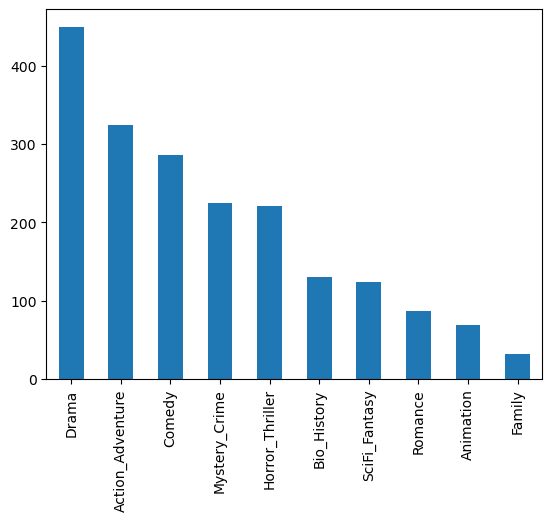

In [1667]:
### plot total genre counts
imdf[['item_id'] + genre_cols].drop_duplicates().drop(
    ['item_id'], axis=1).astype(float).sum().sort_values(ascending=False).plot(kind='bar')

In [1668]:
# instantiate LabelEncoder() and apply onto categorical col
labelencoder = LabelEncoder()
imdf['content_rating'] = labelencoder.fit_transform(imdf['content_rating'])
imdf['covid'] = labelencoder.fit_transform(imdf['covid'])


# cast categorical column as string / object column
# imdf['Cluster'] = imdf['Cluster'].astype(str)
# imdf['season'] = imdf['season'].astype(str)
# imdf['rating'] = imdf['rating'].astype(str)
# imdf['Action_Adventure'] = imdf['Action_Adventure'].astype(str)

imdf = imdf.astype(str)


In [1669]:
# create item meta data without cold start item as model input -- used for inference/training
imdf_non_coldstart = imdf[imdf.item_id.isin(train_data.item_id.tolist())]
# imdf_without_coldstart_item.to_csv('data/itemMetaDatawithoutColdstart.csv', index=False)

# create item meta data with only cold start items, this need prediction/testing
imdf_coldstart = imdf[imdf.item_id.isin(test_data.item_id.tolist())]
# imdf_with_coldstart_item.to_csv('data/itemMetaDataOnlyColdstart.csv', index=False)

print('train data - data w/o coldstart')
print(imdf_non_coldstart.shape)
display(imdf_non_coldstart.tail())
print('\n')

print('test data - data that needs coldstart')
print(imdf_coldstart.shape)
display(imdf_coldstart.tail())

train data - data w/o coldstart
(665, 17)


,item_id,Cluster,view_count_cume,edits_cume,Action_Adventure,Animation,Comedy,SciFi_Fantasy,Drama,Family,Mystery_Crime,Bio_History,Horror_Thriller,Romance,content_rating,covid,franchise
18313,991,2,1234942.0,152.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2,0,0.0
18341,992,6,579199.0,184.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2,0,0.0
18369,994,9,1664543.0,347.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0
18397,996,5,2482049.0,166.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2,0,0.0
18425,997,6,748920.0,96.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,0,0.0




test data - data that needs coldstart
(167, 17)


,item_id,Cluster,view_count_cume,edits_cume,Action_Adventure,Animation,Comedy,SciFi_Fantasy,Drama,Family,Mystery_Crime,Bio_History,Horror_Thriller,Romance,content_rating,covid,franchise
22963,972,6,629682.0,153.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2,0,1.0
22991,979,3,139894.0,41.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2,0,0.0
23019,985,5,2253775.0,132.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2,0,0.0
23047,988,6,1020289.0,129.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2,0,0.0
23075,993,3,364440.0,109.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1,0,0.0


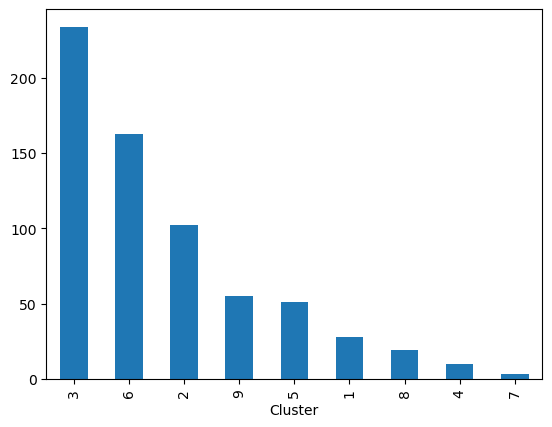

In [1670]:
imdf_non_coldstart['Cluster'].value_counts().plot(kind='bar');

### prepare metrics dataset
(daily value to be predicted from training)

In [1671]:
# known_cov = ['days_in_release', 'weekday', 'Cluster','covid']


static_cov = ['Cluster','content_rating','covid','franchise'] + genre_cols

# known_cov += static_cov

#### tabular dataframe -- use this one!!
1) basic prediction from trained data  
1b) for each cluster, train a model for forecast...
2) take individual films within cluster, forecast based on test data parameters, then average results

In [1672]:
train_data.head(2)

,date,days_in_release,weekday_name,franchise,content_rating,daily_gross,theaters,item_id,Cluster,view_count_cume,...,Memorial Day,New Year's Day,New Year's Eve,Thanksgiving Day,Fall,Holiday,Spring,Summer,Winter,train_test
0,2021-11-26,1,Friday,0.0,R,141595.0,4.0,1001,6,913340.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,train
1,2021-11-27,2,Saturday,0.0,R,104764.0,4.0,1001,6,913340.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,train


In [1707]:
ag_df = TabularDataset(train_data)

## add locs -- known covariate
# ag_df = pd.merge(ag_df, train_test_df[['date','item_id']], 
#                  on=['date','item_id'])

## dont need item_id or date in raw data
ag_df = ag_df[['days_in_release','daily_gross','theaters',
               'view_count_cume','edits_cume',
               'weekday_name',
              ] + static_cov +
             holidays_seasons_dummies.columns.tolist()].drop(['date'], axis=1)


## convert weekday to dummies
# ag_df['weekday'] = ag_df['date'].dt.weekday
# ag_df['weekday'] = ag_df['weekday'].astype(str)

ag_df[['Mon','Tue','Wed','Thu','Fri','Sat','Sun']] = pd.get_dummies(ag_df['weekday_name'],dtype=int).astype(str)
ag_df.drop(['weekday_name'], axis=1, inplace=True)

ag_df["Cluster"] = ag_df["Cluster"].astype(str)
ag_df["days_in_release"] = ag_df["days_in_release"].astype(str)
ag_df["covid"] = ag_df["covid"].astype(str)
ag_df["franchise"] = ag_df["franchise"].astype(str)


ag_df[['PG','PG-13','R']] = pd.get_dummies(ag_df['content_rating'],dtype=int).astype(str)
ag_df.drop(['content_rating'], axis=1, inplace=True)

# ag_df['weekday_name'] = labelencoder.fit_transform(ag_df['weekday_name']).astype(str)
# ag_df['content_rating'] = labelencoder.fit_transform(ag_df['content_rating']).astype(str)

# ## transform daily gross to log
ag_df['theaters_log'] = np.log(ag_df['theaters'])
ag_df['daily_gross_log'] = np.log(ag_df['daily_gross'])
ag_df['view_count_cume_log'] = np.log(ag_df['view_count_cume'])
ag_df['edits_log'] = np.log(ag_df['edits_cume'])


ag_df.drop(['daily_gross','view_count_cume','theaters','edits_cume'], axis=1, inplace=True)

## day_num and weekday are known covariates
print(ag_df.shape)
ag_df.head()

(18453, 43)


,days_in_release,Cluster,covid,franchise,Action_Adventure,Animation,Comedy,SciFi_Fantasy,Drama,Family,...,Fri,Sat,Sun,PG,PG-13,R,theaters_log,daily_gross_log,view_count_cume_log,edits_log
0,1,6,covid,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,1,1.386294,11.860726,13.724863,5.713733
1,2,6,covid,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,1,1.386294,11.559465,13.724863,5.713733
2,3,6,covid,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,1,1.386294,11.500833,13.724863,5.713733
3,4,6,covid,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,1,1.386294,10.856920,13.724863,5.713733
4,5,6,covid,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0,1,0,0,0,1,1.386294,10.753126,13.724863,5.713733


In [1755]:
save_path = 'wiki_boxoffice_coldstart'
eval_metric = 'mse' #mape #r2

In [1775]:
deepar_params = {
    "scaling":True
}

ag_predictor = TabularPredictor(path=save_path, 
                                eval_metric=eval_metric, 
                                problem_type='regression',
#                                    quantile_levels=[0.1,0.5,0.9],
                                   label="daily_gross_log")

ag_predictor.fit(ag_df, presets='good_quality', ## remove presets param for quicker training
    hyperparameters = {
        "LR":{},
        "XGB":{},
        "GBM":{},
        "CAT":{},
        "RF":{},
        "KNN":{},
        "NN_TORCH":{},
#         "Chronos": {},
#         "PatchTST": {},
#         "AutoARIMA": {},
#         "SeasonalNaive": {},
#         "FASTAI": {},
#         "TiDE":{}
})

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.11.4
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.4.0: Fri Apr 11 18:33:46 PDT 2025; root:xnu-11417.101.15~117/RELEASE_ARM64_T8112
CPU Count:          8
Memory Avail:       1.32 GB / 8.00 GB (16.4%)
Disk Space Avail:   15.03 GB / 228.27 GB (6.6%)
Presets specified: ['good_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is enabled (dynamic_stacking=True). A

	-0.6056	 = Validation score   (-mean_squared_error)
	0.02s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 1781.34s of the 2672.73s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=1.11%)
	-0.0589	 = Validation score   (-mean_squared_error)
	16.88s	 = Training   runtime
	49.63s	 = Validation runtime
Fitting model: RandomForest_BAG_L1 ... Training model for up to 1754.25s of the 2645.63s of remaining time.
/Users/jenniferlittle/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
	-0.1843	 = Validation score   (-mean_squared_error)
	2.99s	 = Training   runtime
	0.41s	 = Validation runt

	0.19s	 = Training   runtime
Fitting 1 L2 models, fit_strategy="sequential" ...
Fitting model: NeuralNetTorch_BAG_L2_FULL ...
	1.85s	 = Training   runtime
Fitting model: WeightedEnsemble_L3_FULL | Skipping fit via cloning parent ...
	Ensemble Weights: {'CatBoost_BAG_L2': 0.4, 'RandomForest_BAG_L2': 0.2, 'XGBoost_BAG_L2': 0.2, 'LinearModel_BAG_L2': 0.2}
	0.06s	 = Training   runtime
Updated best model to "WeightedEnsemble_L3_FULL" (Previously "WeightedEnsemble_L3"). AutoGluon will default to using "WeightedEnsemble_L3_FULL" for predict() and predict_proba().
Refit complete, total runtime = 155.69s ... Best model: "WeightedEnsemble_L3_FULL"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/Users/jenniferlittle/Documents/Fordham MSDS/CISC 5800 Machine Learning/project/mlproject/wiki_boxoffice_coldstart")


In [1776]:
feat_import = ag_predictor.feature_importance(ag_df)

Computing feature importance via permutation shuffling for 42 features using 5000 rows with 5 shuffle sets...
/Users/jenniferlittle/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/jenniferlittle/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
	611.01s	= Expected runtime (122.2s per shuffle set)
/Users/jenniferlittle/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using ot

In [1777]:
feat_import

,importance,stddev,p_value,n,p99_high,p99_low
theaters_log,4.640471,0.116644,4.786496e-08,5,4.880642,4.400299
days_in_release,0.508208,0.016271,1.259045e-07,5,0.541709,0.474706
view_count_cume_log,0.346463,0.008695,4.756661e-08,5,0.364366,0.328559
edits_log,0.189752,0.004088,2.583567e-08,5,0.198169,0.181335
Wed,0.148855,0.007201,6.552384e-07,5,0.163683,0.134028
covid,0.117211,0.002894,4.455589e-08,5,0.123170,0.111253
Cluster,0.082124,0.002014,4.332876e-08,5,0.086270,0.077978
Thu,0.050200,0.002161,4.110914e-07,5,0.054650,0.045750
Mon,0.044269,0.002142,6.558687e-07,5,0.048680,0.039858
Fri,0.032506,0.001707,9.089002e-07,5,0.036021,0.028992


### EVALUATE model performance

In [1778]:
ag_predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.047300,mean_squared_error,58.474865,730.439552,0.000497,0.062294,3,False,15
1,CatBoost_BAG_L2,-0.048618,mean_squared_error,57.477010,713.618897,0.096303,120.993489,2,False,11
2,XGBoost_BAG_L2,-0.049158,mean_squared_error,57.625276,596.372443,0.244568,3.747035,2,False,12
3,LightGBM_BAG_L2,-0.049628,mean_squared_error,57.836887,594.950086,0.456179,2.324678,2,False,9
4,RandomForest_BAG_L2,-0.050015,mean_squared_error,58.029422,605.283564,0.648715,12.658156,2,False,10
5,LinearModel_BAG_L2,-0.050201,mean_squared_error,57.484782,592.978578,0.104075,0.353170,2,False,13
6,WeightedEnsemble_L2,-0.051966,mean_squared_error,50.200175,550.919785,0.000284,0.040946,2,False,8
7,CatBoost_BAG_L1,-0.055954,mean_squared_error,0.258132,254.653247,0.258132,254.653247,1,False,4
8,LightGBM_BAG_L1,-0.058908,mean_squared_error,49.625270,16.882059,49.625270,16.882059,1,False,2
9,NeuralNetTorch_BAG_L2,-0.061396,mean_squared_error,57.545882,608.624120,0.165175,15.998712,2,False,14


In [1782]:
# If you have more than one model trained, you can selectively call the best model based on performance
ag_predictor._trainer.get_model_best()

'WeightedEnsemble_L3'

### Model forecasting on cold start item

In [1783]:
train_data.head(3)

,date,days_in_release,weekday_name,franchise,content_rating,daily_gross,theaters,item_id,Cluster,view_count_cume,...,Memorial Day,New Year's Day,New Year's Eve,Thanksgiving Day,Fall,Holiday,Spring,Summer,Winter,train_test
0,2021-11-26,1,Friday,0.0,R,141595.0,4.0,1001,6,913340.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,train
1,2021-11-27,2,Saturday,0.0,R,104764.0,4.0,1001,6,913340.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,train
2,2021-11-28,3,Sunday,0.0,R,98798.0,4.0,1001,6,913340.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,train


In [1784]:
static_cov

['Cluster',
 'content_rating',
 'covid',
 'franchise',
 'Action_Adventure',
 'Animation',
 'Comedy',
 'SciFi_Fantasy',
 'Drama',
 'Family',
 'Mystery_Crime',
 'Bio_History',
 'Horror_Thriller',
 'Romance']

In [1785]:
ag_df.columns

Index(['days_in_release', 'Cluster', 'covid', 'franchise', 'Action_Adventure',
       'Animation', 'Comedy', 'SciFi_Fantasy', 'Drama', 'Family',
       'Mystery_Crime', 'Bio_History', 'Horror_Thriller', 'Romance',
       'Christmas Day', 'Christmas Eve', 'Columbus Day', 'Independence Day',
       'Labor Day', 'Martin Luther King Jr. Day', 'Memorial Day',
       'New Year's Day', 'New Year's Eve', 'Thanksgiving Day', 'Fall',
       'Holiday', 'Spring', 'Summer', 'Winter', 'Mon', 'Tue', 'Wed', 'Thu',
       'Fri', 'Sat', 'Sun', 'PG', 'PG-13', 'R', 'theaters_log',
       'daily_gross_log', 'view_count_cume_log', 'edits_log'],
      dtype='object')

In [1786]:
cstdf = TabularDataset(test_data)

## dont need item_id or date in raw data
cstdf = cstdf[['item_id','days_in_release','theaters',
               'view_count_cume','edits_cume','weekday_name',
              ] + static_cov +
             holidays_seasons_dummies.columns.tolist()].drop(['date'], axis=1)


## convert weekday to dummies
# ag_df['weekday'] = ag_df['date'].dt.weekday
# ag_df['weekday'] = ag_df['weekday'].astype(str)

cstdf[['Mon','Tue','Wed','Thu','Fri','Sat','Sun']] = pd.get_dummies(cstdf['weekday_name'], dtype=int).astype(str)
cstdf.drop(['weekday_name'], axis=1, inplace=True)


cstdf["Cluster"] = cstdf["Cluster"].astype(str)
cstdf["days_in_release"] = cstdf["days_in_release"].astype(str)
cstdf["covid"] = cstdf["covid"].astype(str)

cstdf['content_rating'] = labelencoder.fit_transform(cstdf['content_rating']).astype(str)

# ## transform daily gross to log
cstdf['daily_gross_log'] = np.nan ## add empty column for prediction (daily_gross)

cstdf['view_count_cume_log'] = np.log(cstdf['view_count_cume'])
cstdf['theaters_log'] = np.log(cstdf['theaters'])
cstdf['edits_log'] = np.log(cstdf['edits_cume'])

cstdf.drop(['view_count_cume','theaters','edits_cume'], axis=1, inplace=True)

cstdf[['PG','PG-13','R']] = pd.get_dummies(cstdf['content_rating'],dtype=int).astype(str)
cstdf.drop(['content_rating'], axis=1, inplace=True)


## only 2 weeks...
cstdf = cstdf[cstdf['days_in_release'].astype(int) <= 14]


print(cstdf.shape)
print(cstdf.item_id.nunique())
cstdf.head()

(2338, 44)
167


,item_id,days_in_release,Cluster,covid,franchise,Action_Adventure,Animation,Comedy,SciFi_Fantasy,Drama,...,Fri,Sat,Sun,daily_gross_log,view_count_cume_log,theaters_log,edits_log,PG,PG-13,R
28,1006,1,2,covid,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,NaN,13.752851,7.944492,6.159095,0,1,0
29,1006,2,2,covid,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,NaN,13.752851,7.944492,6.159095,0,1,0
30,1006,3,2,covid,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,NaN,13.752851,7.944492,6.159095,0,1,0
31,1006,4,2,covid,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,NaN,13.752851,7.944492,6.159095,0,1,0
32,1006,5,2,covid,0.0,0.0,0.0,0.0,0.0,1.0,...,0,1,0,NaN,13.752851,7.944492,6.159095,0,1,0


### TABULAR prediction on test set

In [1787]:
cstdf.columns

Index(['item_id', 'days_in_release', 'Cluster', 'covid', 'franchise',
       'Action_Adventure', 'Animation', 'Comedy', 'SciFi_Fantasy', 'Drama',
       'Family', 'Mystery_Crime', 'Bio_History', 'Horror_Thriller', 'Romance',
       'Christmas Day', 'Christmas Eve', 'Columbus Day', 'Independence Day',
       'Labor Day', 'Martin Luther King Jr. Day', 'Memorial Day',
       'New Year's Day', 'New Year's Eve', 'Thanksgiving Day', 'Fall',
       'Holiday', 'Spring', 'Summer', 'Winter', 'Mon', 'Tue', 'Wed', 'Thu',
       'Fri', 'Sat', 'Sun', 'daily_gross_log', 'view_count_cume_log',
       'theaters_log', 'edits_log', 'PG', 'PG-13', 'R'],
      dtype='object')

In [1788]:
## TABULAR PREDICTION
cstdf2 = cstdf[['item_id'] + ag_df.columns.tolist()]

print(cstdf2.shape)
cstdf2.head(3)

(2338, 44)


,item_id,days_in_release,Cluster,covid,franchise,Action_Adventure,Animation,Comedy,SciFi_Fantasy,Drama,...,Fri,Sat,Sun,PG,PG-13,R,theaters_log,daily_gross_log,view_count_cume_log,edits_log
28,1006,1,2,covid,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,1,0,7.944492,NaN,13.752851,6.159095
29,1006,2,2,covid,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,1,0,7.944492,NaN,13.752851,6.159095
30,1006,3,2,covid,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,1,0,7.944492,NaN,13.752851,6.159095


In [1789]:
# cold_start_prediction = ag_predictor.predict(cstdf, static_features=imdf_with_coldstart_item)

cold_start_prediction = pd.DataFrame(ag_predictor.predict(cstdf2).apply(lambda x: np.exp(x)).round())
# cold_start_prediction.astype(str)
cold_start_prediction.columns = ['daily_gross_pred']
cold_start_prediction

/Users/jenniferlittle/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/jenniferlittle/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,daily_gross_pred
28,3439073.0
29,3274843.0
30,2500688.0
31,1099962.0
32,1200950.0
...,...
23000,86091.0
23001,41583.0
23002,48003.0
23003,77039.0


#### test set evaluation

In [1790]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

In [1791]:
mape_ = mean_absolute_percentage_error(test_data[(test_data['days_in_release'] <= 14)]['daily_gross'],
                                 cold_start_prediction)

In [1792]:
r2_ = r2_score(test_data[(test_data['days_in_release'] <= 14)]['daily_gross'],
                                 cold_start_prediction)

In [1793]:
mse_ = mean_squared_error(test_data[(test_data['days_in_release'] <= 14)]['daily_gross'],
                                 cold_start_prediction)

In [1794]:
pd.DataFrame([[mape_, r2_, mse_]], columns=['mape','r2','mse'])

,mape,r2,mse
0,0.601145,0.848479,5.096827e+12


In [1795]:
final_preds = pd.merge(wiki_training2[['title','item_id','date','days_in_release','daily_gross']].astype(str), 
         cstdf2[['item_id','days_in_release']].join(cold_start_prediction))

final_preds.head(50)

,title,item_id,date,days_in_release,daily_gross,daily_gross_pred
0,80 for Brady,1125,2023-02-03,1,4625369.0,6896159.0
1,80 for Brady,1125,2023-02-04,2,4480357.0,7286506.0
2,80 for Brady,1125,2023-02-05,3,3595914.0,4377930.0
3,80 for Brady,1125,2023-02-06,4,1210212.0,1377074.0
4,80 for Brady,1125,2023-02-07,5,2540127.0,1612964.0
5,80 for Brady,1125,2023-02-08,6,1333386.0,983651.0
6,80 for Brady,1125,2023-02-09,7,1184293.0,927930.0
7,80 for Brady,1125,2023-02-10,8,1849260.0,2562594.0
8,80 for Brady,1125,2023-02-11,9,2824718.0,4452975.0
9,80 for Brady,1125,2023-02-12,10,1126327.0,2520042.0


In [1528]:
final_preds['title'].unique().tolist()

['80 for Brady',
 'A Journal for Jordan',
 'A Man Called Otto',
 'Accountant, The',
 'Ad Astra',
 'American Animals',
 'American Assassin',
 'Anora',
 'Avatar: The Way of Water',
 'BFG, The',
 'Bad Boys: Ride or Die',
 'Batman, The',
 'Belfast',
 'Belko Experiment, The',
 'Better Man',
 'Big Sick, The',
 'BlacKkKlansman',
 'Blade Runner 2049',
 'Blinded By The Light',
 'Boss Baby, The',
 'Brahms: The Boy II',
 'Breathe (2017)',
 'Brightburn',
 'Captain America: Civil War',
 'Challengers',
 "Charlie's Angels",
 'Clemency',
 'Conclave',
 'Creed II',
 'Criminal',
 'Current War, The',
 'Darkest Hour',
 'Deadpool 2',
 'Despicable Me 3',
 'Different Man, A',
 "Don't Breathe 2",
 'Dragon Ball Super: Broly',
 'Dream Scenario',
 'Eye In The Sky',
 'Ferdinand',
 'Fighting With My Family',
 'Flatliners',
 'Fly Me to the Moon',
 'Ford v. Ferrari',
 'Freaky',
 'Geostorm',
 'Goldfinch, The',
 'Goodbye Christopher Robin',
 "Gosnell: The Trial Of America's Biggest Serial Killer",
 'Greatest Showman, T

In [1796]:
final_preds[final_preds['title'] == 'Wild Robot, The']

,title,item_id,date,days_in_release,daily_gross,daily_gross_pred
2212,"Wild Robot, The",1354,2024-09-27,1,11197075.0,9139657.0
2213,"Wild Robot, The",1354,2024-09-28,2,14405440.0,9029559.0
2214,"Wild Robot, The",1354,2024-09-29,3,10187635.0,6504299.0
2215,"Wild Robot, The",1354,2024-09-30,4,2295955.0,1766593.0
2216,"Wild Robot, The",1354,2024-10-01,5,3123780.0,2865971.0
2217,"Wild Robot, The",1354,2024-10-02,6,1822355.0,1686118.0
2218,"Wild Robot, The",1354,2024-10-03,7,2251820.0,1548227.0
2219,"Wild Robot, The",1354,2024-10-04,8,4926820.0,3591639.0
2220,"Wild Robot, The",1354,2024-10-05,9,8153915.0,5598470.0
2221,"Wild Robot, The",1354,2024-10-06,10,5815330.0,3880666.0


### export predictions

In [ ]:
final_preds.to_csv('final_predictions.csv')